<img src="mioti.png" style="height: 100px">
<center style="color:#888">Data Science in IoT<br/>Asignatura: Predictive Analytics</center>

# Challenge S1: Introducción a las series Temporales

## 0. Objetivo

<img src="bicicletas_chicago_challenge.jpg" style="float:right; height: 250px"></img>
El objetivo de este challenge es realizar el análisis de una serie temporal y eliminar sus componentes de estacionalidad y tendencia.

Vamos a utilizar el dataset de los alquileres de bicicletas de Chicago, pero en este caso utilizaremos como serie temporal el número de **alquileres de los usuarios registrados**.

Además, realizaremos el análisis con los **datos a nivel horario**, es decir, sin agrupar.

## 1. Preparar el contexto

Como paso previo, cargamos las librerías que serán necesarias en nuestro estudio.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
## Definimos las variables para determinar el tamaño de las gráficas
fig_size = (18,6)
fig_size_subplot = (14,7)

## 2. Pretratado de los datos

Recuerda que en este ejercicio, debemos leer nuestro fichero y crear un dataframe con la serie temporal que incluya nuestra variable tiempo y el número de alquileres de usuarios registrados.

In [2]:
## Carga del fichero
data_path = 'hour_chicago.csv'
df_datos = pd.read_csv(data_path)
df_datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date_str    17379 non-null  object 
 1   season      17379 non-null  int64  
 2   yr          17379 non-null  int64  
 3   mnth        17379 non-null  int64  
 4   hr          17379 non-null  int64  
 5   holiday     17379 non-null  int64  
 6   weekday     17379 non-null  int64  
 7   workingday  17379 non-null  int64  
 8   temp        17379 non-null  float64
 9   hum         17379 non-null  float64
 10  windspeed   17379 non-null  float64
 11  casual      17379 non-null  int64  
 12  registered  17379 non-null  int64  
 13  cnt         17379 non-null  int64  
dtypes: float64(3), int64(10), object(1)
memory usage: 1.9+ MB


In [3]:
## Creación de la variable tiempo
df_datos['date_hr'] = (df_datos['date_str'].map(str) + ' ' + df_datos['hr'].map(str) + ':00:00')
df_datos['date_hr'] = pd.to_datetime(df_datos['date_hr'])
df_datos['date'] = df_datos['date_hr'].dt.strftime('%Y-%m-%d %H:%M:%S')
df_datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date_str    17379 non-null  object        
 1   season      17379 non-null  int64         
 2   yr          17379 non-null  int64         
 3   mnth        17379 non-null  int64         
 4   hr          17379 non-null  int64         
 5   holiday     17379 non-null  int64         
 6   weekday     17379 non-null  int64         
 7   workingday  17379 non-null  int64         
 8   temp        17379 non-null  float64       
 9   hum         17379 non-null  float64       
 10  windspeed   17379 non-null  float64       
 11  casual      17379 non-null  int64         
 12  registered  17379 non-null  int64         
 13  cnt         17379 non-null  int64         
 14  date_hr     17379 non-null  datetime64[ns]
 15  date        17379 non-null  object        
dtypes: datetime64[ns](1), 

In [4]:
df_datos.index = pd.to_datetime(df_datos['date'])
df_datos.head()
df_datos.drop(columns=['date'])

,date_str,season,yr,mnth,hr,holiday,weekday,workingday,temp,hum,windspeed,casual,registered,cnt,date_hr
date,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01,1,0,1,0,0,6,0,0.24,0.81,0.0000,3,13,16,2011-01-01 00:00:00
2011-01-01 01:00:00,2011-01-01,1,0,1,1,0,6,0,0.22,0.80,0.0000,8,32,40,2011-01-01 01:00:00
2011-01-01 02:00:00,2011-01-01,1,0,1,2,0,6,0,0.22,0.80,0.0000,5,27,32,2011-01-01 02:00:00
2011-01-01 03:00:00,2011-01-01,1,0,1,3,0,6,0,0.24,0.75,0.0000,3,10,13,2011-01-01 03:00:00
2011-01-01 04:00:00,2011-01-01,1,0,1,4,0,6,0,0.24,0.75,0.0000,0,1,1,2011-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,2012-12-31,1,1,12,19,0,1,1,0.26,0.60,0.1642,11,108,119,2012-12-31 19:00:00
2012-12-31 20:00:00,2012-12-31,1,1,12,20,0,1,1,0.26,0.60,0.1642,8,81,89,2012-12-31 20:00:00
2012-12-31 21:00:00,2012-12-31,1,1,12,21,0,1,1,0.26,0.60,0.1642,7,83,90,2012-12-31 21:00:00


In [5]:
## Creación del dataframe con nuestra serie temporal
df_TimeSeriesData = pd.DataFrame(df_datos['registered'])
df_TimeSeriesData.head()

,registered
date,
2011-01-01 00:00:00,13
2011-01-01 01:00:00,32
2011-01-01 02:00:00,27
2011-01-01 03:00:00,10
2011-01-01 04:00:00,1


In [6]:
df_TimeSeriesData.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17379 entries, 2011-01-01 00:00:00 to 2012-12-31 23:00:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   registered  17379 non-null  int64
dtypes: int64(1)
memory usage: 271.5 KB


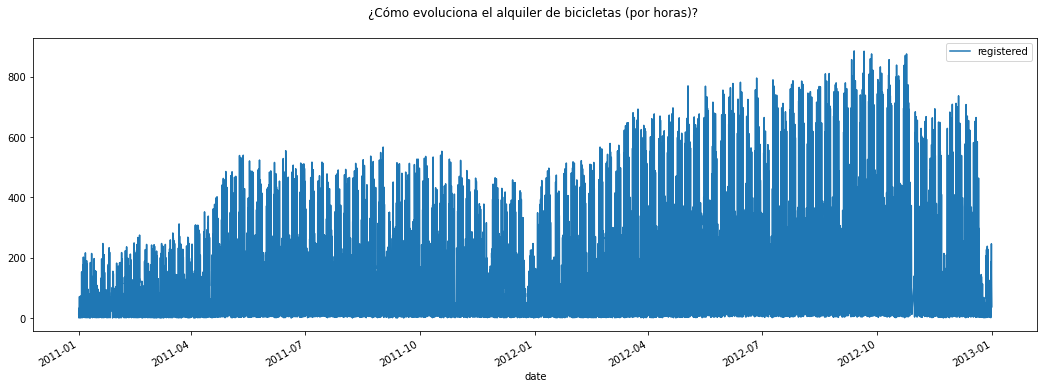

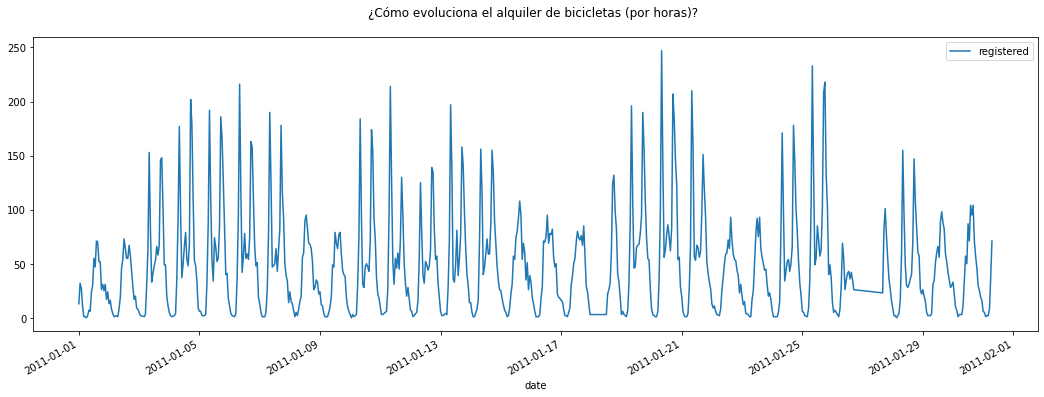

In [7]:
## Visualización de nuestra serie temporal
df_TimeSeriesData.plot(figsize = fig_size,\
                       title = '¿Cómo evoluciona el alquiler de bicicletas (por horas)? \n')

## Hacemos un zoom sobre unos cuantos días para apreciar mejor el comportamiento
df_TimeSeriesData[:(24*7*4)].plot(figsize = fig_size,\
                       title = '¿Cómo evoluciona el alquiler de bicicletas (por horas)? \n')


## 3. Componentes de una serie temporal

**P: ¿Qué componentes tiene nuestra serie temporal?**

Estacionalidad y tendencia.

**P: ¿Hay más de un tipo de estacionalidad?**

Estacionalidad diaria / semanal y otra anual y tendencia positiva

### 3.1. Si existe componente estacional, elimínala y representa los resultados.

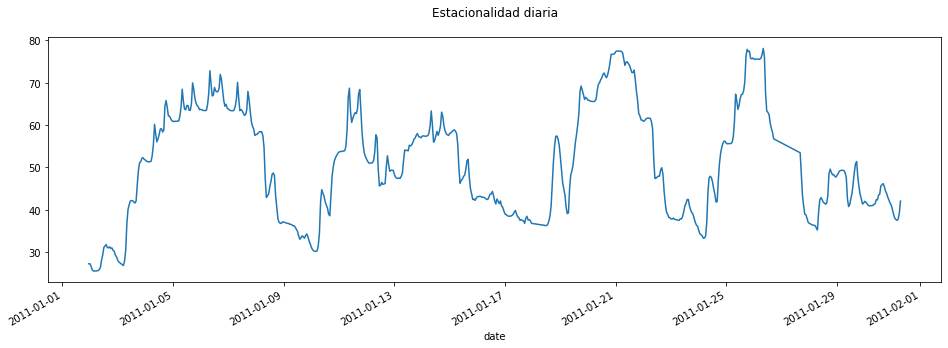

In [8]:
#df_TimeSeriesData[-24*30:].plot(figsize=(16,5))
# Primero hacemos ventanas de 24 horas para quitar la estacionalidad diaria
df_TimeSeriesData['reg_mm24'] = df_TimeSeriesData.rolling(24).mean()
df_TimeSeriesData['reg_mm24'][:24*7*4].plot(figsize=(16,5),title = 'Estacionalidad diaria\n')



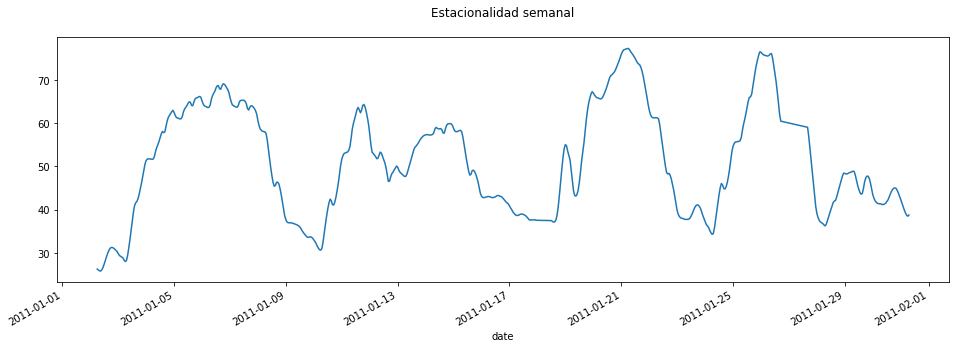

In [9]:
# Quitamos la estcionalidad semanal
df_TimeSeriesData['reg_mm24_7'] = df_TimeSeriesData.reg_mm24.rolling(7).mean()
df_TimeSeriesData['reg_mm24_7'][:24*7*4].plot(figsize=(16,5),title = 'Estacionalidad semanal\n')

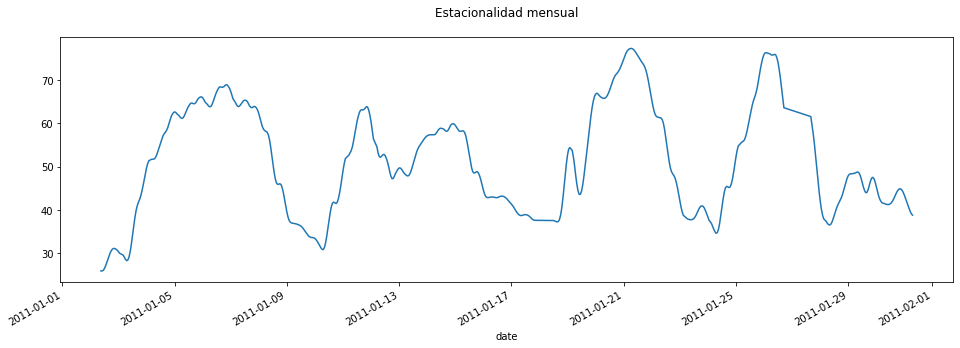

In [10]:
## Quitamos la estcionalidad mensual
df_TimeSeriesData['reg_mm24_7_4'] = df_TimeSeriesData.reg_mm24_7.rolling(4).mean()
df_TimeSeriesData['reg_mm24_7_4'][:24*7*4].plot(figsize=(16,5),title = 'Estacionalidad mensual\n')

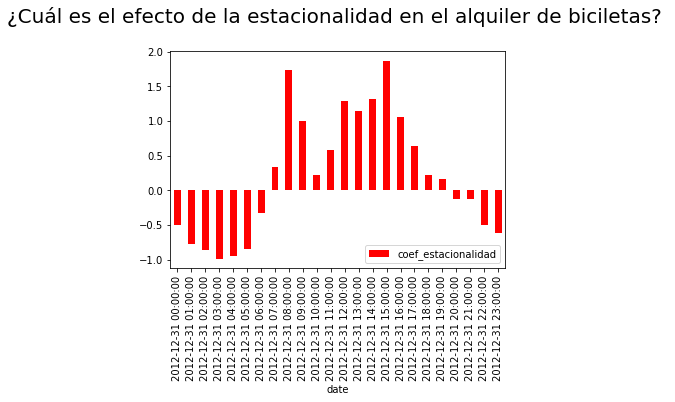

In [11]:
# Calculamos el coeficiente de estacionalidad
df_TimeSeriesData['coef_estacionalidad']=df_TimeSeriesData['registered']/df_TimeSeriesData['reg_mm24']
(df_TimeSeriesData['coef_estacionalidad'][-24:]-1).plot(kind='bar',color='red')
plt.title('¿Cuál es el efecto de la estacionalidad en el alquiler de biciletas? \n',fontsize= 20)
plt.legend()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11a0ce290>,
      dtype=object)

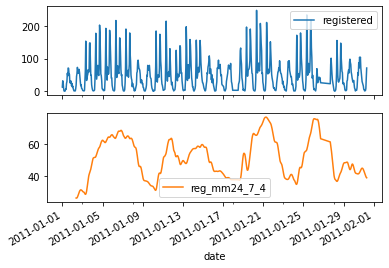

In [15]:
# Representamos la serie con y sin estacionalidad
df_TimeSeriesData = df_TimeSeriesData[['registered','reg_mm24_7_4']]
df_TimeSeriesData[:24*7*4].iloc[:,:2].plot(subplots = True)

### 3.2. Si existe tendencia, elimínala y representa los resultados.

In [13]:
df_TimeSeriesData_trend = df_TimeSeriesData.copy()
df_TimeSeriesData_trend['cnt_mm24_sin_tendencia'] = df_TimeSeriesData_trend['reg_mm24_7_4'] - \
                                                      df_TimeSeriesData_trend['reg_mm24_7_4'].shift(1)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11a337090>,
      dtype=object)

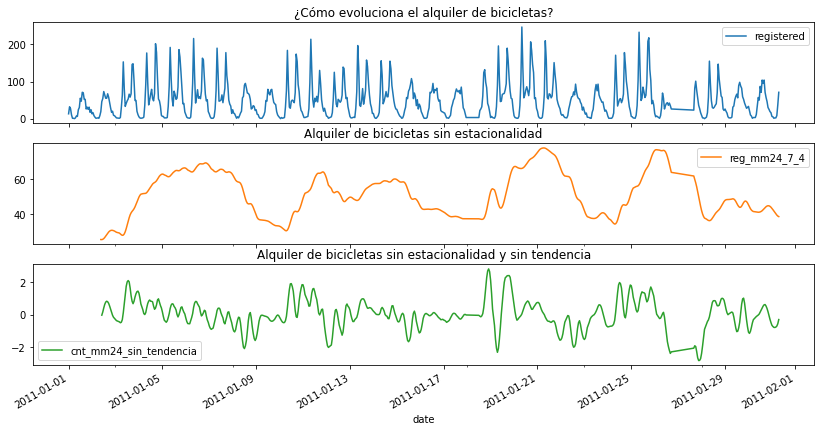

In [14]:
## Representamos la serie temporal, la serie sin estacionalidad y la serie sin tendencia 
df_TimeSeriesData_trend[:24*7*4].loc[:,['registered','reg_mm24_7_4','cnt_mm24_sin_tendencia']].plot(subplots = True,
                                          title = ['¿Cómo evoluciona el alquiler de bicicletas?',\
                                                   'Alquiler de bicicletas sin estacionalidad', \
                                                   'Alquiler de bicicletas sin estacionalidad y sin tendencia'],
                                          figsize = fig_size_subplot)
